## Churn Rate Prediction
### using XGBoost

**Churn**
- It the measure of how many customers stop using a product.
- Measured based on actual usage or failure to renew (when the product is sold using a subscription model).
- Evaluated for a specific period of time (monthly, quarterly, or annual).

**The Dataset**
Kaggle link: [dataset](https://www.kaggle.com/datasets/ermismbatuhan/digital-marketing-ecommerce-customer-behavior)

### 1) Imports

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

### 2) Dataframe

In [23]:
# Create dataframe
df = pd.read_csv("Ecomm Data.csv", sep = ";")
df.head(7)

,account length,location code,user id,credit card info save,push status,add to wishlist,desktop sessions,app sessions,desktop transactions,total product detail views,session duration,promotion clicks,avg order value,sale product views,discount rate per visited products,product detail view per app session,app transactions,add to cart per session,customer service calls,churn
0,128,415,3824657,no,yes,25,265,45,17,110,197,87,"244,7",91,"11,01",10,3,"2,7",1,0
1,107,415,3717191,no,yes,26,162,27,17,123,196,103,"254,4",103,"11,45","13,7",3,"3,7",1,0
2,137,415,3581921,no,no,0,243,41,10,114,121,110,"162,6",104,"7,32","12,2",5,"3,29",0,0
3,84,408,3759999,yes,no,0,299,51,5,71,62,88,"196,9",89,"8,86","6,6",7,"1,78",2,0
4,75,415,3306626,yes,no,0,167,28,13,113,148,122,"186,9",121,"8,41","10,1",3,"2,73",3,0
5,118,510,3918027,yes,no,0,223,38,19,98,221,101,"203,9",118,"9,18","6,3",6,"1,7",0,0
6,121,510,3559993,no,yes,24,218,37,30,88,349,108,"212,6",118,"9,57","7,5",7,"2,03",3,0


### 3) Data Preprocessing

In [24]:
df.info() # check variables and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   account length                       3333 non-null   int64 
 1   location code                        3333 non-null   int64 
 2   user id                              3333 non-null   int64 
 3   credit card info save                3333 non-null   object
 4   push status                          3333 non-null   object
 5   add to wishlist                      3333 non-null   int64 
 6   desktop sessions                     3333 non-null   int64 
 7   app sessions                         3333 non-null   int64 
 8   desktop transactions                 3333 non-null   int64 
 9   total product detail views           3333 non-null   int64 
 10  session duration                     3333 non-null   int64 
 11  promotion clicks                     3333 n

### Data Type conversions
- ```location code``` converted to a category (3 unique values)
- ```credit card info save``` converted to a binomial category of 0 ('no') or 1 ('yes')
- same for ```push status```

In [25]:
df["location code"].unique()

array([415, 408, 510])

In [26]:
# Convert to a category
df["location code"] = df["location code"].astype(str)

In [27]:
df["credit card info save"].unique()

array(['no', 'yes'], dtype=object)

In [28]:
# Changing the values from yes and no to 1 and 0
df["credit card info save"] = df["credit card info save"].replace({"yes": 1, "no": 0})
df["push status"] = df["push status"].replace({"yes": 1, "no": 0})

In [29]:
# Changing from comma (,) notation (many EU countries use this) to point (.) for decimals
df["avg order value"] = df["avg order value"].str.replace(',','.').astype(float)
df["discount rate per visited products"] = df["discount rate per visited products"].str.replace(',','.').astype(float)
df["product detail view per app session"] = df["product detail view per app session"].str.replace(',','.').astype(float)
df["add to cart per session"] = df["add to cart per session"].str.replace(',','.').astype(float)

In [30]:
df = pd.get_dummies(df, columns = ["location code"])

Since this is an overall Churn Rate analysis, ```user id``` is irrelevant and is dropped.

In [31]:
df = df.drop("user id", axis = 1)

### Normalize the columns
- typical preprocessing to standardize data around 0 and have comparable variance

In [32]:
cols_to_scale = ['account length',
       'add to wishlist', 'desktop sessions', 'app sessions',
       'desktop transactions', 'total product detail views',
       'session duration', 'promotion clicks', 'avg order value',
       'sale product views', 'discount rate per visited products',
       'product detail view per app session', 'app transactions',
       'add to cart per session', 'customer service calls']
scaler = Normalizer()
scaled_data =scaler.fit_transform(df[cols_to_scale])
scaled_df = pd.DataFrame(scaled_data, index = df.index, columns = cols_to_scale)

### Train:Test split
- I like a 25% split. Usually it's set at 20%.

In [33]:
# Train-test splitting
X = df.drop("churn", axis=1)
y = df["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=86)

### XGBoost

In [46]:
# XGBoost model : Train
xgb_cl = xgb.XGBClassifier(n_estimators = 250, learning_rate = 0.05, random_state = 86,
                          max_depth = 3, verbose = True)
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, ...)

In [47]:
# XGBoost model: Test
# Predicting on the test data (X_test)
preds = xgb_cl.predict(X_test)

In [48]:
acc = accuracy_score(y_test, preds)
print("Model Accuracy for Test Dataset:", acc)

Model Accuracy for Test Dataset: 0.9496402877697842


### Slightly more advanced stuff: tuning hyperparameters
- Cross-validation and grid search of some hyperparameter values for improvement, using ```GridSearchCV```

In [37]:
# hyperparameter tuning
param_grid = {
    "max_depth": [5, 7, 10, 12],
    "learning_rate": [0.01, 0.05, 0.025],
    "gamma": [1, 2, 3, 4, 5, 6, 7],
    "scale_pos_weight": [1, 2, 5],
    "n_estimators": [50, 100, 250, 500],
    "subsample":[1],
    "colsample_bytree": [1]
}
xgb_opt = xgb.XGBClassifier(objective="binary:logistic", verbose = True, random_state = 86)
grid_cv = GridSearchCV(xgb_opt, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
_ = grid_cv.fit(X_train, y_train)
print("The Best Score:", grid_cv.best_score_)
print("The Best Params:", grid_cv.best_params_)

The Best Score: 0.9170335249831564
The Best Params: {'colsample_bytree': 1, 'gamma': 3, 'learning_rate': 0.025, 'max_depth': 5, 'n_estimators': 50, 'scale_pos_weight': 1, 'subsample': 1}


In [42]:
# using the best model
xgb_fin = xgb.XGBClassifier(
    **grid_cv.best_params_, objective="binary:logistic"
)
grid_final = xgb_fin.fit(X_train, y_train)
y_pred = grid_final.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy of the Final Model:", acc)

Accuracy of the Final Model: 0.9568345323741008


## Conclusion

The "best" model has a CV best score of 0.9241, and the model's accuracy is 95.69% which is pretty good, and a slight improvement over the initial "guess" model in terms of accuracy.

### Advanced Visualizations and Evaluations

**Key metrics**:
- *Precision*: how many predicted churns were actual churns
- *Recall*: how many actual churns were correctly predicted
- *F1-score*: harmonic mean of precision and recall

In [49]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen’s Kappa: {kappa:.4f}")


Precision: 0.9639
Recall: 0.7080
F1 Score: 0.8163
Cohen’s Kappa: 0.7925


**Confusion Matrix Heatmap**

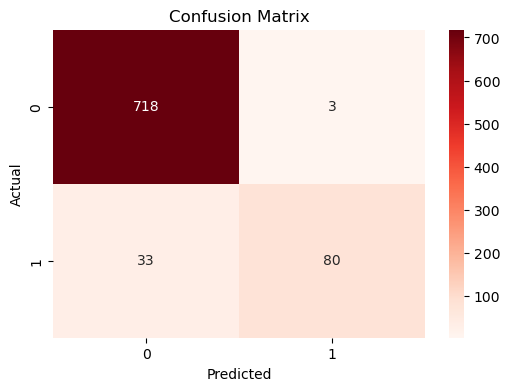

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Feature Importance (KPIs)

<Figure size 500x500 with 0 Axes>

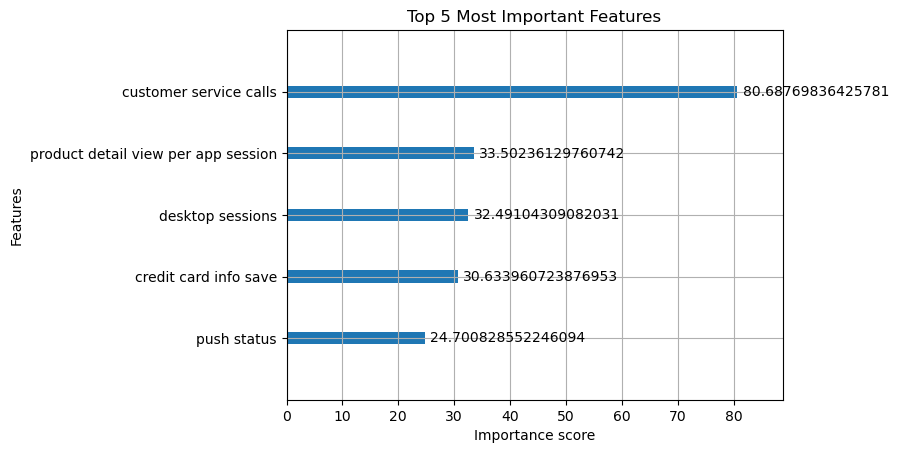

In [51]:
from xgboost import plot_importance

plt.figure(figsize=(5,5))
plot_importance(grid_final, importance_type='gain', max_num_features=5)
plt.title("Top 5 Most Important Features")
plt.show()